In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset, DataLoader

In [2]:
def split(X, y, seed, z=None, train_size=0.7, test_size=0.3, val_size=0.2):
    X_val = None
    y_val = None
    Z_train, Z_val, Z_test = None, None, None
    if train_size is None and test_size is None:
        raise AttributeError()
    elif train_size is None:
        train_size = 1. - test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                        train_size=train_size)
    if z is not None:
        Z_train, Z_test = train_test_split(z, stratify=y, random_state=seed, shuffle=True, train_size=train_size)
    if val_size is not None:
        if z is not None:
            Z_train, Z_val = train_test_split(Z_train, stratify=y_train, random_state=seed, shuffle=True,
                                              test_size=val_size)

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=seed,
                                                          shuffle=True, test_size=val_size)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test)



In [3]:
def get_dataset(
        df: str | pd.DataFrame = 'dataset/EDOS_1M_balanced.pkl',
        seed=0
):
    df = df
    if isinstance(df, str):
        if df.endswith('pkl'):
            df = pd.read_pickle(df)
        else:
            df = pd.read_csv(df)
    groups = []
    labels = []
    confidence = []
    for name, group in df.groupby(by='eb+_emot'):
        group = group.reset_index(drop=True)
        groups.append(group.loc[:, 'uttr'])
        confidence.append(group.loc[:, 'label_confidence'])
        labels.append(group.loc[:, 'eb+_emot'])

    groups = np.array(groups, dtype=str)
    labels = np.array(labels, dtype=str)

    confidence = np.array(confidence, dtype=np.float32)
    return groups, labels, confidence


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
groups, labels, confidence = get_dataset()

In [6]:

unique = np.unique(labels.flatten())
emotions_to_category = {key: value for key, value in zip(unique, range(len(unique)))}
category_to_emotion = {key: value for key, value in zip(range(len(unique)), unique)}


def label_convert(label):
    return emotions_to_category[label]

In [7]:
labels = np.vectorize(label_convert)(labels)

In [8]:
class OurDataset(Dataset):
    def __init__(self, X, y, z):
        self.X = X
        self.y = y
        self.z = z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item], self.z[item]

In [9]:
seed = 0
(X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test) = split(groups.flatten(),
                                                                                       labels.flatten(), seed,
                                                                                       confidence.flatten())
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(196950,)
(105510,)
(49238,)


In [10]:
train_dataset = OurDataset(X_train, y_train, Z_train)
test_dataset = OurDataset(X_test, y_test, Z_test)
val_dataset = OurDataset(X_val, y_val, Z_val)

In [11]:
def collate_fn(batch):
    global tokenizer
    x, y, z = [], [], []
    for x1, y1, z1 in batch:
        x.append(x1)
        y.append(y1)
        z.append(z1)
    batch = tokenizer(x, padding=True, return_tensors='pt')
    y = torch.as_tensor(y)
    z = torch.as_tensor(z, dtype=torch.float32)
    return batch, y, z

    # print(x)

In [12]:
generator = torch.Generator().manual_seed(0)
sampling_train = torch.utils.data.RandomSampler(train_dataset, num_samples=1000, replacement=False, generator=generator)
sampling_test = torch.utils.data.RandomSampler(test_dataset, num_samples=1000, replacement=False, generator=generator)
sampling_val = torch.utils.data.RandomSampler(val_dataset, num_samples=1000, replacement=False, generator=generator)
train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, sampler=sampling_train)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, sampler=sampling_test)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, sampler=sampling_val)

In [13]:
class EmotionClassifierConcat(nn.Module):
    def __init__(self, output_size, device, hidden_layers, activation_fn=nn.ReLU, dropout_value=0.):
        super(EmotionClassifierConcat, self).__init__()
        config = AutoConfig.from_pretrained("bert-base-uncased")
        config.update({"output_hidden_states": True})
        self.encoder = AutoModel.from_pretrained("bert-base-uncased", config=config)
        self.encoder.eval()
        # self.last_n_hidden_state = last_n_hidden_state
        self.classification = nn.Sequential(
        )
        for i in range(len(hidden_layers)):
            curr = hidden_layers[i]
            if i == 0:
                self.classification.append(nn.LazyLinear(curr))
                self.classification.append(activation_fn())
                if dropout_value > 0:
                    self.classification.append(nn.Dropout(dropout_value))
                continue
            prev = hidden_layers[i - 1]
            self.classification.append(nn.Linear(prev, curr))
            self.classification.append(activation_fn())
            if dropout_value > 0:
                self.classification.append(nn.Dropout(dropout_value))

        self.classification.append(nn.Linear(hidden_layers[-1], output_size))
        self.classification.append(nn.Softmax(dim=-1))

        self.device = device

    def forward(self, batch):
        with torch.no_grad():
            x = self.encoder(batch['input_ids'].to(self.device),
                             batch['attention_mask'].to(self.device))  # TODO: check against ** batch
            hidden_states = torch.stack(x["hidden_states"])
            concatenated = torch.cat((hidden_states[-1], hidden_states[-2], hidden_states[-3], hidden_states[-4]), -1)
            concatenated = concatenated[:, 0]
        return self.classification(concatenated)


class EmotionClassifierWeightedPooling(nn.Module):
    def __init__(self,
                 output_size,
                 device,
                 hidden_layers,
                 start_layer,
                 activation_fn=nn.ReLU,
                 dropout_value=0.,
                 total_hidden_states=13
                 ):
        super(EmotionClassifierWeightedPooling, self).__init__()
        config = AutoConfig.from_pretrained("bert-base-uncased")
        config.update({"output_hidden_states": True})
        self.encoder = AutoModel.from_pretrained("bert-base-uncased", config=config)
        self.encoder.eval()
        self.start_layer = start_layer
        # self.last_n_hidden_state = last_n_hidden_state
        self.classification = nn.Sequential(
        )
        for i in range(len(hidden_layers)):
            curr = hidden_layers[i]
            if i == 0:
                self.classification.append(nn.LazyLinear(curr))
                self.classification.append(activation_fn())
                if dropout_value > 0:
                    self.classification.append(nn.Dropout(dropout_value))
                continue
            prev = hidden_layers[i - 1]
            self.classification.append(nn.Linear(prev, curr))
            self.classification.append(activation_fn())
            if dropout_value > 0:
                self.classification.append(nn.Dropout(dropout_value))

        self.classification.append(nn.Linear(hidden_layers[-1], output_size))
        self.classification.append(nn.Softmax(dim=-1))

        self.device = device

        # wieght # 64, 61, 768
        self.layer_weight = nn.Parameter(
            torch.full(size=(total_hidden_states - start_layer, 1, 1, 1), fill_value=1, dtype=torch.float32,
                       requires_grad=True))

    def forward(self, batch):
        with torch.no_grad():
            x = self.encoder(batch['input_ids'].to(self.device),
                             batch['attention_mask'].to(self.device))  # TODO: check against ** batch
            hidden_states = torch.stack(x["hidden_states"])
            hidden_states = hidden_states[self.start_layer:, :, :, :]
            weight_factor = self.layer_weight.expand(hidden_states.size())
            weighted_average = (weight_factor * hidden_states).sum(dim=0) / self.layer_weight.sum()
        return self.classification(weighted_average[:, 0])



In [80]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy().argmax(-1)
    accuracy = accuracy_score(y_true, y_pred)
    f1_score_value = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1_score_value


def decode(input_, y_true, y_pred, confidence, top_5=True):
    global tokenizer, category_to_emotion

    input_ = input_[0].detach().cpu()
    y_true = y_true[0].detach().cpu().item()
    y_pred = y_pred[0].detach().cpu().numpy()
    true_confidence = confidence[0]
    pred_confidence = y_pred.max()
    top_5_emotions = None
    if top_5:
        index = y_pred.argsort()[-5:]
        top_5_emotions = [category_to_emotion[i] for i in index]
    y_pred = y_pred.argmax()
    input_ = tokenizer.decode(input_)
    y_true = category_to_emotion[y_true]
    y_pred = category_to_emotion[y_pred]
    return input_, y_true, y_pred, true_confidence, pred_confidence, top_5_emotions


def conv_fn(x):
    global category_to_emotion
    return category_to_emotion[x]


def top(y_true, y_pred, top_n=5):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    y_true = np.vectorize(conv_fn)(y_true)
    y_pred = np.argsort(y_pred)[:, -5:]
    y_pred = np.vectorize(conv_fn)(y_pred)
    return np.mean(np.isin(y_true, y_pred))






In [81]:
from torchsummary import summary
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")


class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.best_val = np.inf
        self.counter = 0

    def __call__(self, val: float):
        save = False
        if val < self.best_val:
            self.counter = 0
            self.best_val = val
            save = True
        else:
            self.counter += 1
        return self.counter >= self.patience, save


class Trainer:
    def __init__(self,
                 model: nn.Module,
                 model_name: str,
                 device,
                 dataloaders: tuple[DataLoader, DataLoader, DataLoader | None],
                 optimizer=torch.optim.AdamW,
                 scheduler=None,
                 lr: float = 1e-3,
                 output_dir: str = './RESULTS',
                 patience: int = 10,
                 verbose=0,
                 ):
        self.model_name = model_name
        self.device = device
        self.output_dir = output_dir

        self.model = model
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optimizer(self.model.parameters(), lr=lr)
        self.scheduler = scheduler
        self.verbose = verbose
        self.train_loader, self.test_loader, self.val_loader = dataloaders

        self.train_loss = []
        self.train_accuracy = []
        self.train_f1_score = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.validation_f1_score = []
        self.validation_is_in_top_5 = []

        self.early_stopper = EarlyStopping(patience)

        if not os.path.exists(output_dir):
            os.mkdir(output_dir)

    def print_architecture(self, batch_size=64):  #TODO: NOT WORKING
        print(summary(self.model.classification, input_size=(3072,), batch_size=batch_size, device=self.device))

    def reset_params(self):
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1_score = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.validation_f1_score = []
        self.validation_is_in_top_5 = []

    def draw_training_metrics(self, save=True, format='pdf', figsize=(16, 8), step=1):
        if len(self.train_loss) == 0:
            return
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Training metrics')
        axs[0].plot(self.train_loss, label='Train')
        axs[0].plot(self.validation_loss, label='Validation')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].set_xticks(np.arange(0, len(self.train_loss), step))
        axs[0].legend()

        axs[1].plot(self.train_accuracy, label='Train')
        axs[1].plot(self.validation_accuracy, label='Validation')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_xticks(np.arange(0, len(self.train_accuracy), step))
        axs[1].legend()

        axs[2].plot(self.train_f1_score, label='Train')
        axs[2].plot(self.validation_f1_score, label='Validation')
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('F1 Score')
        axs[2].set_xticks(np.arange(0, len(self.train_f1_score), step))
        axs[2].legend()

        plt.tight_layout()
        if save:
            plt.savefig(f'{self.output_dir}/{self.model_name}_train_metrics.{format}', bbox_inches='tight')
        plt.show()

    def draw_top_5(self, save=True, format='pdf', figsize=(16, 8), step=1):
        fig = plt.figure(figsize=figsize)
        plt.plot(self.validation_is_in_top_5)
        plt.xlabel('Epochs')
        plt.tight_layout()
        if save:
            plt.savefig(f'{self.output_dir}/{self.model_name}_top_5.{format}', bbox_inches='tight')
        plt.show()

    def train_model(self, epochs):
        self.reset_params()
        loader_length = len(self.train_loader)
        for ep in range(1, epochs + 1):
            self.model.train()
            loss_ep: float = 0.
            accuracy_ep: float = 0.
            f1_score_ep: float = 0.
            for batch, labels, confidence, in tqdm(self.train_loader):
                out = self.model.forward(batch)
                self.optimizer.zero_grad()
                loss = self.loss_fn(out, labels.to(self.device))
                loss.backward()
                self.optimizer.step()
                loss_ep += loss.item()
                with torch.no_grad():
                    a, f1 = compute_metrics(labels, out)
                    accuracy_ep += a
                    f1_score_ep += f1
            loss_ep /= loader_length
            accuracy_ep /= loader_length
            f1_score_ep /= loader_length
            self.train_loss.append(loss_ep)
            self.train_accuracy.append(accuracy_ep)
            self.train_f1_score.append(f1_score_ep)
            print(f'TRAIN LOSS: {loss_ep:.5f} ; ACCURACY: {accuracy_ep:.5f} ; F1: {f1_score_ep:.5f}')
            if self.val_loader is not None:
                if self.validate():
                    break

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            loss_val = 0
            accuracies = 0
            f1_scores = 0
            length_val_dataloader = len(self.val_loader)
            top_5_ep = 0.
            for idx, (batch, labels, confidence) in enumerate(self.val_loader):
                out = self.model.forward(batch)
                loss = self.loss_fn(out, labels.to(self.device))
                loss_val += loss.item()
                ac, f1 = compute_metrics(labels, out)
                accuracies += ac
                f1_scores += f1
                top_5_ep += top(labels, out)
                if self.verbose:
                    if idx == length_val_dataloader - 1:
                        input_, y_true, y_pred, c_true, c_pred, top_5_emotions = decode(batch['input_ids'], labels, out,
                                                                                        confidence)

            loss_val /= length_val_dataloader
            accuracies /= length_val_dataloader
            f1_scores /= length_val_dataloader
            top_5_ep /= length_val_dataloader
            self.validation_loss.append(loss_val)
            self.validation_accuracy.append(accuracies)
            self.validation_f1_score.append(f1_scores)
            self.validation_is_in_top_5.append(top_5_ep)
            print(
                f'VAL   LOSS: {loss_val:.5f} ; ACCURACY: {accuracies:.5f} ; F1: {f1_scores:.5f} ; top 5: {top_5_ep:.5f}')
            if self.verbose:
                print('INPUT:', input_.replace('[PAD]', '').rstrip())
                print('TRUE LABEL:', y_true, 'conf:', f'{c_true:.5f}')
                print('PREDICTED_LABEL', y_pred, 'conf', f'{c_pred:.5f}')
                if top_5_emotions is not None:
                    print(f'TOP 5: {top_5_emotions}')
            break_, save_ = self.early_stopper(loss_val)
            if save_:
                torch.save(self.model.state_dict(), f'{self.output_dir}/{self.model_name}.pt')
        return break_





In [82]:
OUTPUT_SIZE = len(emotions_to_category)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
hidden_layers = [128, 64]

# model = EmotionClassifierConcat(output_size=OUTPUT_SIZE,
#                                 device=DEVICE,
#                                 hidden_layers=hidden_layers)

model = EmotionClassifierWeightedPooling(
    output_size=OUTPUT_SIZE,
    device=DEVICE,
    hidden_layers=hidden_layers,
    start_layer=4
)

/Users/marziolunghi/Documents/GitHub/ATML-NLP/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [83]:
model_name = 'test1'
output_size = len(emotions_to_category)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)
dataloaders = train_dataloader, test_dataloader, val_dataloader
trainer = Trainer(
    model,
    model_name=model_name,
    device=device,
    dataloaders=dataloaders,
    verbose=1
)

mps


In [84]:
# trainer.print_architecture(64)

In [85]:
trainer.train_model(20)

  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71347 ; ACCURACY: 0.01719 ; F1: 0.00159
VAL   LOSS: 3.71352 ; ACCURACY: 0.02793 ; F1: 0.00421 ; top 5: 0.17090
INPUT: [CLS] see? what i tell you? look. he's loving it. look at him. [SEP]
TRUE LABEL: joyful conf: 0.80042
PREDICTED_LABEL acknowledging conf 0.03669
TOP 5: ['disappointed', 'encouraging', 'joyful', 'disgusted', 'acknowledging']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71333 ; ACCURACY: 0.02207 ; F1: 0.00310
VAL   LOSS: 3.71320 ; ACCURACY: 0.02109 ; F1: 0.00162 ; top 5: 0.21484
INPUT: [CLS] crucified. [SEP]
TRUE LABEL: devastated conf: 0.67203
PREDICTED_LABEL agreeing conf 0.04847
TOP 5: ['terrified', 'caring', 'disappointed', 'acknowledging', 'agreeing']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71282 ; ACCURACY: 0.02891 ; F1: 0.00365
VAL   LOSS: 3.71295 ; ACCURACY: 0.02109 ; F1: 0.00180 ; top 5: 0.19687
INPUT: [CLS] stop it... please don't make me laugh... [SEP]
TRUE LABEL: annoyed conf: 0.82924
PREDICTED_LABEL terrified conf 0.08674
TOP 5: ['embarrassed', 'encouraging', 'agreeing', 'acknowledging', 'terrified']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71065 ; ACCURACY: 0.03379 ; F1: 0.00311
VAL   LOSS: 3.71238 ; ACCURACY: 0.02207 ; F1: 0.00157 ; top 5: 0.13867
INPUT: [CLS] daria, wait. [SEP]
TRUE LABEL: anticipating conf: 0.91455
PREDICTED_LABEL terrified conf 0.31983
TOP 5: ['disappointed', 'disgusted', 'furious', 'acknowledging', 'terrified']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71097 ; ACCURACY: 0.02832 ; F1: 0.00236
VAL   LOSS: 3.71070 ; ACCURACY: 0.03770 ; F1: 0.00588 ; top 5: 0.25000
INPUT: [CLS] there is no a whore in london who would not be glad of such a fee. then find a whore who needs the money. this one's retired. [SEP]
TRUE LABEL: jealous conf: 0.77579
PREDICTED_LABEL terrified conf 0.15651
TOP 5: ['embarrassed', 'agreeing', 'acknowledging', 'disappointed', 'terrified']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71085 ; ACCURACY: 0.03965 ; F1: 0.01590
VAL   LOSS: 3.71031 ; ACCURACY: 0.05684 ; F1: 0.01947 ; top 5: 0.32500
INPUT: [CLS] besides the group needs dancers. we are making a video. [SEP]
TRUE LABEL: confident conf: 0.69426
PREDICTED_LABEL sympathizing conf 0.05839
TOP 5: ['lonely', 'disappointed', 'questioning', 'acknowledging', 'sympathizing']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.71038 ; ACCURACY: 0.04297 ; F1: 0.01483
VAL   LOSS: 3.70570 ; ACCURACY: 0.06465 ; F1: 0.02959 ; top 5: 0.34570
INPUT: [CLS] sheila, duck! [SEP]
TRUE LABEL: furious conf: 0.70470
PREDICTED_LABEL angry conf 0.19469
TOP 5: ['embarrassed', 'encouraging', 'questioning', 'furious', 'angry']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.70237 ; ACCURACY: 0.05723 ; F1: 0.02757
VAL   LOSS: 3.69853 ; ACCURACY: 0.06172 ; F1: 0.02783 ; top 5: 0.25898
INPUT: [CLS] thank you for making the journey. [SEP]
TRUE LABEL: grateful conf: 0.98062
PREDICTED_LABEL acknowledging conf 0.13352
TOP 5: ['terrified', 'caring', 'nostalgic', 'encouraging', 'acknowledging']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.69037 ; ACCURACY: 0.06836 ; F1: 0.03050
VAL   LOSS: 3.69304 ; ACCURACY: 0.06680 ; F1: 0.02696 ; top 5: 0.26387
INPUT: [CLS] unfortunately, i'm the only one left, who was at your daughter's surgery. everybody else quit the hospital. [SEP]
TRUE LABEL: disappointed conf: 0.43857
PREDICTED_LABEL disappointed conf 0.31449
TOP 5: ['afraid', 'neutral', 'acknowledging', 'nostalgic', 'disappointed']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.68663 ; ACCURACY: 0.07207 ; F1: 0.03227
VAL   LOSS: 3.67361 ; ACCURACY: 0.08613 ; F1: 0.04205 ; top 5: 0.32539
INPUT: [CLS] your imam preaches... that once dead, you are destined for paradise and we are destined for hell. [SEP]
TRUE LABEL: faithful conf: 0.52160
PREDICTED_LABEL nostalgic conf 0.20523
TOP 5: ['sad', 'terrified', 'disappointed', 'encouraging', 'nostalgic']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.67924 ; ACCURACY: 0.07930 ; F1: 0.03240
VAL   LOSS: 3.67510 ; ACCURACY: 0.08223 ; F1: 0.03830 ; top 5: 0.35918
INPUT: [CLS] i think anna will be pleased. [SEP]
TRUE LABEL: joyful conf: 0.86456
PREDICTED_LABEL encouraging conf 0.63739
TOP 5: ['hopeful', 'nostalgic', 'caring', 'disappointed', 'encouraging']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.67707 ; ACCURACY: 0.07695 ; F1: 0.02737
VAL   LOSS: 3.66954 ; ACCURACY: 0.07520 ; F1: 0.02471 ; top 5: 0.36582
INPUT: [CLS] anything? jeremy michael haydock, cautioned for cannabis possession last year, half a joint's worth. nothing else. [SEP]
TRUE LABEL: ashamed conf: 0.52645
PREDICTED_LABEL nostalgic conf 0.30039
TOP 5: ['neutral', 'questioning', 'disappointed', 'terrified', 'nostalgic']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.66438 ; ACCURACY: 0.09180 ; F1: 0.04031
VAL   LOSS: 3.65972 ; ACCURACY: 0.09453 ; F1: 0.04523 ; top 5: 0.37207
INPUT: [CLS] eddie. you can't win all the time. but you can't lose forever, either. [SEP]
TRUE LABEL: neutral conf: 0.63787
PREDICTED_LABEL nostalgic conf 0.37496
TOP 5: ['angry', 'disappointed', 'furious', 'terrified', 'nostalgic']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.66358 ; ACCURACY: 0.09766 ; F1: 0.04649
VAL   LOSS: 3.65709 ; ACCURACY: 0.10391 ; F1: 0.04401 ; top 5: 0.32598
INPUT: [CLS] yes, my husband's at work. this is just a routine check, mrs. palmer. [SEP]
TRUE LABEL: content conf: 0.46125
PREDICTED_LABEL sympathizing conf 0.25918
TOP 5: ['nostalgic', 'caring', 'encouraging', 'disappointed', 'sympathizing']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.68160 ; ACCURACY: 0.06934 ; F1: 0.03228
VAL   LOSS: 3.66301 ; ACCURACY: 0.09453 ; F1: 0.04579 ; top 5: 0.30391
INPUT: [CLS] oh, well, i hope i don't look quite so solemn. it isn't really so much like me. [SEP]
TRUE LABEL: consoling conf: 0.74359
PREDICTED_LABEL nostalgic conf 0.56953
TOP 5: ['sympathizing', 'neutral', 'acknowledging', 'disappointed', 'nostalgic']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.67485 ; ACCURACY: 0.07734 ; F1: 0.03820
VAL   LOSS: 3.65419 ; ACCURACY: 0.09492 ; F1: 0.05393 ; top 5: 0.33750
INPUT: [CLS] could you maybe... yeah, right. [SEP]
TRUE LABEL: suggesting conf: 0.90107
PREDICTED_LABEL sympathizing conf 0.54636
TOP 5: ['agreeing', 'encouraging', 'disappointed', 'acknowledging', 'sympathizing']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.65584 ; ACCURACY: 0.10840 ; F1: 0.05735
VAL   LOSS: 3.64606 ; ACCURACY: 0.11133 ; F1: 0.05702 ; top 5: 0.33301
INPUT: [CLS] you scared me i was counting how long i could hold my breath... under the water... it was shorter than i'd thought don '! be silly... you'd get me in a lot of trouble... [SEP]
TRUE LABEL: terrified conf: 0.62378
PREDICTED_LABEL terrified conf 0.59777
TOP 5: ['disappointed', 'acknowledging', 'angry', 'nostalgic', 'terrified']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.65512 ; ACCURACY: 0.09941 ; F1: 0.04709
VAL   LOSS: 3.64412 ; ACCURACY: 0.11367 ; F1: 0.06157 ; top 5: 0.35352
INPUT: [CLS] doesn't that sound nice. [SEP]
TRUE LABEL: acknowledging conf: 0.50403
PREDICTED_LABEL sympathizing conf 0.47770
TOP 5: ['neutral', 'agreeing', 'acknowledging', 'questioning', 'sympathizing']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.63911 ; ACCURACY: 0.11426 ; F1: 0.06194
VAL   LOSS: 3.64015 ; ACCURACY: 0.11992 ; F1: 0.06412 ; top 5: 0.38438
INPUT: [CLS] maybe if i go there... [SEP]
TRUE LABEL: suggesting conf: 0.86189
PREDICTED_LABEL acknowledging conf 0.27274
TOP 5: ['trusting', 'agreeing', 'sympathizing', 'encouraging', 'acknowledging']


  0%|          | 0/16 [00:00<?, ?it/s]

TRAIN LOSS: 3.65139 ; ACCURACY: 0.10840 ; F1: 0.06184
VAL   LOSS: 3.63469 ; ACCURACY: 0.12793 ; F1: 0.06607 ; top 5: 0.37969
INPUT: [CLS] dunno. my street source, bucket, deals out these clubs. he's been in the wind for a week. something's up. [SEP]
TRUE LABEL: disappointed conf: 0.43713
PREDICTED_LABEL nostalgic conf 0.24150
TOP 5: ['sympathizing', 'guilty', 'disappointed', 'neutral', 'nostalgic']


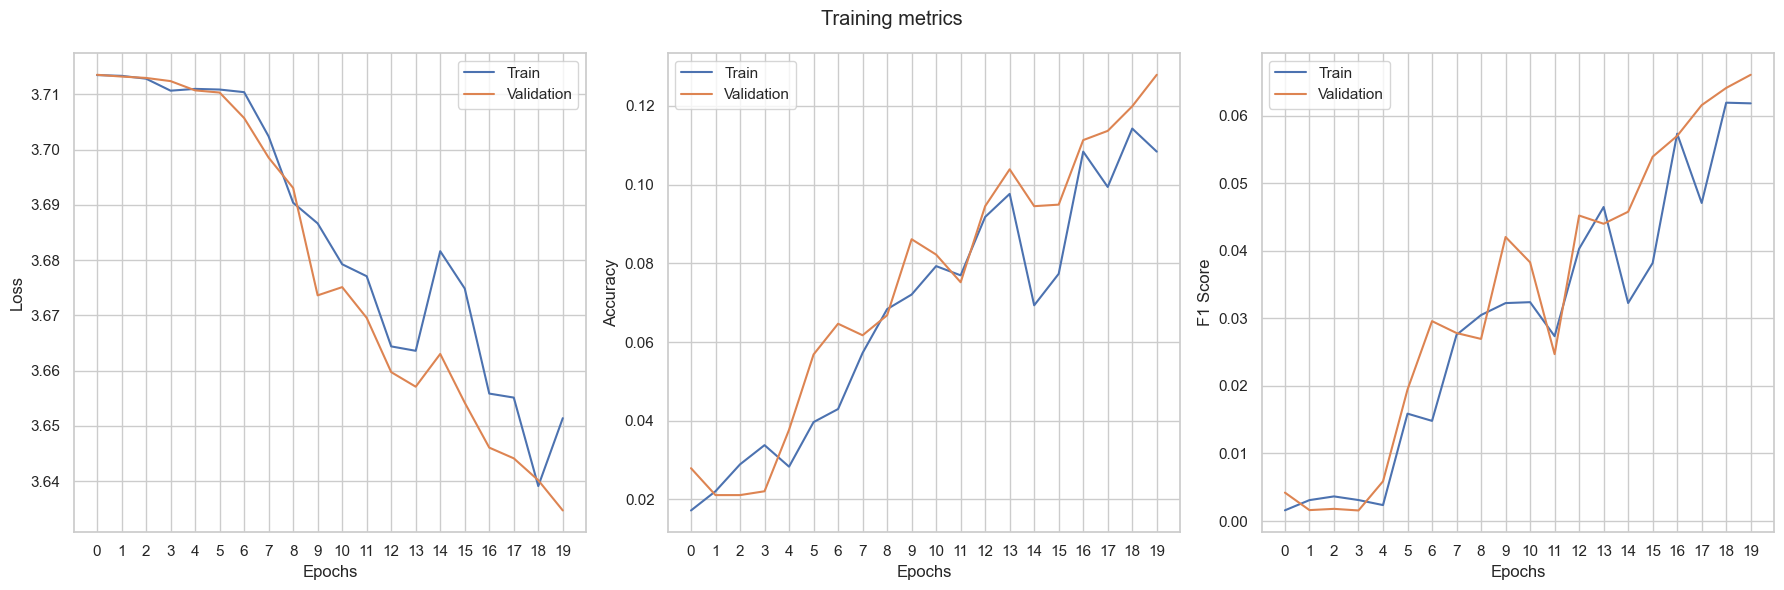

In [86]:
trainer.draw_training_metrics(save=False, figsize=(18, 6))

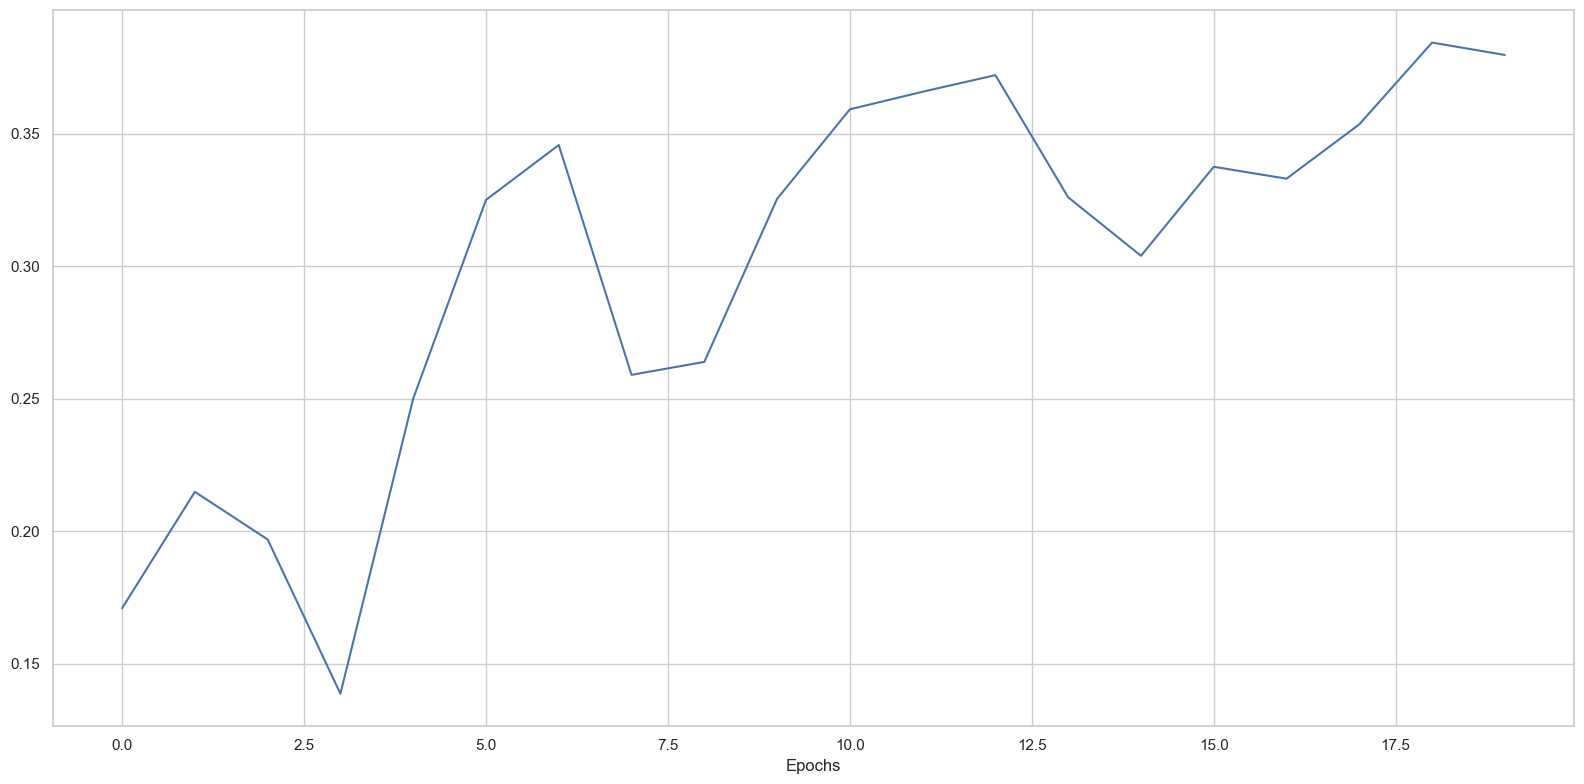

In [87]:
trainer.draw_top_5(save=False)

In [113]:
import sys
import time


def dialogue(model: EmotionClassifierWeightedPooling | EmotionClassifierConcat, deterministic=True):
    global category_to_emotion
    model.eval()
    with torch.no_grad():
        while True:
            user_text = input('ENTER SENTENCE:')
            if user_text.lower() == 'exit' or len(user_text) == 0:
                print('BYE!')
                return
            print(f'USER: {user_text}')
            assert isinstance(user_text, str)
            batch = tokenizer(user_text, padding=True, return_tensors='pt')
            prediction = model.forward(batch).cpu().numpy().flatten()
            if deterministic:
                predicated_label = prediction.argmax(-1)
                probability = np.max(prediction)
                predicated_label = category_to_emotion[predicated_label]
                top_5_prediction = prediction.argsort()[-5:]
                top_5_probability = prediction[top_5_prediction][::-1]
                top_5 = np.vectorize(conv_fn)(top_5_prediction)[::-1]
                dictionary = {key: value for key, value in zip(top_5, top_5_probability)}
                print(f'BOT: {predicated_label} with prob: {probability}')
                print(f'TOP 5: {dictionary}')
            time.sleep(2)




In [114]:
dialogue(model)

USER: You are a monster!
BOT: angry with prob: 0.8826571106910706
TOP 5: {'angry': 0.8826571, 'furious': 0.08947631, 'terrified': 0.021272369, 'questioning': 0.0038393447, 'acknowledging': 0.0013006532}
BYE!
